In [10]:
%matplotlib inline


.. currentmodule:: dgl

Graph Classification Tutorial
=============================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

In this tutorial, you learn how to use DGL to batch multiple graphs of variable size and shape. The 
tutorial also demonstrates training a graph neural network for a simple graph classification task.

Graph classification is an important problem
with applications across many fields, such as bioinformatics, chemoinformatics, social
network analysis, urban computing, and cybersecurity. Applying graph neural
networks to this problem has been a popular approach recently. This can be seen in the following reserach references: 
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).


Simple graph classification task
--------------------------------
In this tutorial, you learn how to perform batched graph classification
with DGL. The example task objective is to classify eight types of topologies shown here.

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png)

    :align: center

Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight 
different types of graphs and each class has the same number of graph samples.



In [11]:
# from dgl.data import MiniGCDataset
# import matplotlib.pyplot as plt
# import networkx as nx
# # A dataset with 80 samples, each graph is
# # of size [10, 20]
# dataset = MiniGCDataset(80, 10, 20)
# print(dataset[0])
# graph, label = dataset[0]
# fig, ax = plt.subplots()
# nx.draw(graph.to_networkx(), ax=ax)
# ax.set_title('Class: {:d}'.format(label))
# plt.show()

In [12]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of :func:`dgl.batch` is still a graph. In the same way, 
a batch of tensors is still a tensor. This means that any code that works
for one graph immediately works for a batch of graphs. More importantly,
because DGL processes messages on all nodes and edges in parallel, this greatly
improves efficiency.

Graph classifier
----------------
Graph classification proceeds as follows.

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png)


From a batch of graphs, perform message passing and graph convolution
for nodes to communicate with others. After message passing, compute a
tensor for graph representation from node (and edge) attributes. This step might 
be called readout or aggregation. Finally, the graph 
representations are fed into a classifier $g$ to predict the graph labels.

Graph convolution
-----------------
The graph convolution operation is basically the same as that for graph convolutional network (GCN). To learn more, 
see the GCN `tutorial <https://docs.dgl.ai/tutorials/models/1_gnn/1_gcn.html>`_). The only difference is
that we replace $h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)$ 
by
$h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\frac{1}{|\mathcal{N}(v)|}\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)$

The replacement of summation by average is to balance nodes with different
degrees. This gives a better performance for this experiment.

The self edges added in the dataset initialization allows you to
include the original node feature $h_{v}^{(l)}$ when taking the average.



In [13]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

Readout and classification
--------------------------
For this demonstration, consider initial node features to be their degrees.
After two rounds of graph convolution, perform a graph readout by averaging
over all node features for each graph in the batch.

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. You then feed the graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [14]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

## Rewrite Graph Generation Class

In [15]:
"""A mini synthetic dataset for graph classification benchmark."""
import math
import networkx as nx
import numpy as np

from dgl.graph import DGLGraph

__all__ = ['MiniGCDataset']

class MiniGCDataset_4c(object):
    """The dataset class.

    The datset contains 8 different types of graphs.

    * class 0 : cycle graph
    * class 1 : star graph
    * class 2 : wheel graph
    * class 3 : lollipop graph

    .. note::
        This dataset class is compatible with pytorch's :class:`Dataset` class.

    Parameters
    ----------
    num_graphs: int
        Number of graphs in this dataset.
    min_num_v: int
        Minimum number of nodes for graphs
    max_num_v: int
        Maximum number of nodes for graphs
    """
    def __init__(self, num_graphs, min_num_v, max_num_v):
        super(MiniGCDataset_4c, self).__init__()
        self.num_graphs = num_graphs
        self.min_num_v = min_num_v
        self.max_num_v = max_num_v
        self.graphs = []
        self.labels = []
        self._generate()

    def __len__(self):
        """Return the number of graphs in the dataset."""
        return len(self.graphs)


    def __getitem__(self, idx):
        """Get the i^th sample.

        Paramters
        ---------
        idx : int
            The sample index.

        Returns
        -------
        (dgl.DGLGraph, int)
            The graph and its label.
        """
        return self.graphs[idx], self.labels[idx]


    @property
    def num_classes(self):
        """Number of classes."""
        return 4

    def _generate(self):
        self._gen_cycle(self.num_graphs // 4)
        self._gen_star(self.num_graphs // 4)
        self._gen_wheel(self.num_graphs // 4)
        self._gen_lollipop(self.num_graphs - len(self.graphs))
#         self._gen_lollipop(self.num_graphs // 8)
#         self._gen_hypercube(self.num_graphs // 8)
#         self._gen_grid(self.num_graphs // 8)
#         self._gen_clique(self.num_graphs // 8)
#         self._gen_circular_ladder(self.num_graphs - len(self.graphs))
        # preprocess
        for i in range(self.num_graphs):
            self.graphs[i] = DGLGraph(self.graphs[i])
            # add self edges
            nodes = self.graphs[i].nodes()
            self.graphs[i].add_edges(nodes, nodes)

    def _gen_cycle(self, n):
        for _ in range(n):
            num_v = np.random.randint(self.min_num_v, self.max_num_v)
            g = nx.cycle_graph(num_v)
            self.graphs.append(g)
            self.labels.append(0)

    def _gen_star(self, n):
        for _ in range(n):
            num_v = np.random.randint(self.min_num_v, self.max_num_v)
            # nx.star_graph(N) gives a star graph with N+1 nodes
            g = nx.star_graph(num_v - 1)
            self.graphs.append(g)
            self.labels.append(1)

    def _gen_wheel(self, n):
        for _ in range(n):
            num_v = np.random.randint(self.min_num_v, self.max_num_v)
            g = nx.wheel_graph(num_v)
            self.graphs.append(g)
            self.labels.append(2)

    def _gen_lollipop(self, n):
        for _ in range(n):
            num_v = np.random.randint(self.min_num_v, self.max_num_v)
            path_len = np.random.randint(2, num_v // 2)
            g = nx.lollipop_graph(m=num_v - path_len, n=path_len)
            self.graphs.append(g)
            self.labels.append(3)

Setup and training
------------------
Create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [16]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
# trainset = MiniGCDataset(320, 10, 20)
trainset = MiniGCDataset_4c(20, 10, 60)
testset = MiniGCDataset_4c(200, 10, 60)
print(trainset)

In [17]:
trainset.labels

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]

In [18]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=1, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(500):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
#         print(label)
#         print(prediction)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.2944
Epoch 1, loss 2.0993
Epoch 2, loss 1.9579
Epoch 3, loss 1.4522
Epoch 4, loss 1.4279
Epoch 5, loss 1.5402
Epoch 6, loss 1.3594
Epoch 7, loss 1.2516
Epoch 8, loss 1.3624
Epoch 9, loss 1.4473
Epoch 10, loss 1.1501
Epoch 11, loss 1.0221
Epoch 12, loss 1.0385
Epoch 13, loss 1.0149
Epoch 14, loss 0.9588
Epoch 15, loss 0.9361
Epoch 16, loss 0.9542
Epoch 17, loss 0.8631
Epoch 18, loss 0.9222
Epoch 19, loss 0.8745
Epoch 20, loss 0.9228
Epoch 21, loss 1.0210
Epoch 22, loss 0.8356
Epoch 23, loss 0.8596
Epoch 24, loss 0.8636
Epoch 25, loss 0.8697
Epoch 26, loss 0.8409
Epoch 27, loss 0.8619
Epoch 28, loss 0.8003
Epoch 29, loss 0.8172
Epoch 30, loss 0.8431
Epoch 31, loss 0.7872
Epoch 32, loss 0.7532
Epoch 33, loss 0.7567
Epoch 34, loss 0.8284
Epoch 35, loss 0.8095
Epoch 36, loss 0.7078
Epoch 37, loss 0.7526
Epoch 38, loss 0.7552
Epoch 39, loss 0.8190
Epoch 40, loss 0.7554
Epoch 41, loss 0.7181
Epoch 42, loss 0.7444
Epoch 43, loss 0.7269
Epoch 44, loss 0.7210
Epoch 45, loss 0.786

The learning curve of a run is presented below.



In [19]:
import matplotlib.pyplot as plt

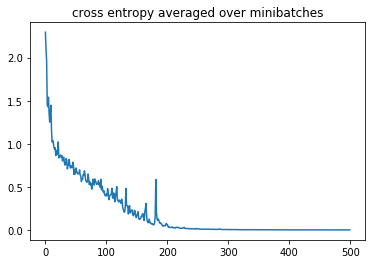

In [20]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created. To deploy
the tutorial, restrict the running time to get a higher
accuracy ($80$ % ~ $90$ %) than the ones printed below.



In [21]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))

# print(test_X)
# print(test_Y)
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 95.5000%
Accuracy of argmax predictions on the test set: 95.500000%


## Finish Training and Testing

## End